<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#test" data-toc-modified-id="test-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>test</a></span></li></ul></div>

In [1]:
import pandas as pd
import copy
import pprint
import xlsxwriter
from vega import VegaLite

#显示所有列
pd.set_option('display.max_columns', 20)
# pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', 20)
# pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

In [2]:
class My_DataFrame(pd.DataFrame):
    def __init__(self, data=None, index=None, columns=None, dtype=None, copy=False):
        pd.DataFrame.__init__(self, data, index, columns, dtype, copy)
 
    def my_mergewr_excel(self,path,key_cols=None,merge_cols=[]):
        # sheet_name='Sheet1', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, startrow=0, startcol=0, engine=None, merge_cells=True, encoding=None, inf_rep='inf', verbose=True):
        self_copy=My_DataFrame(self,copy=True)
        line_cn=self_copy.index.size
        cols=list(self_copy.columns.values)
#         if all([v in cols for i,v in enumerate(key_cols)])==False:     #校验key_cols中各元素 是否都包含与对象的列
#             print("key_cols is not completely include object's columns")
#             return False
        if all([v in cols for i,v in enumerate(merge_cols)])==False:  #校验merge_cols中各元素 是否都包含与对象的列
            print("merge_cols is not completely include object's columns")
            return False    
 
        wb2007 = xlsxwriter.Workbook(path)
        worksheet2007 = wb2007.add_worksheet()
        format_top = wb2007.add_format({'border':1,'bold':True,'text_wrap':True})
        format_other = wb2007.add_format({'border':1,'valign':'vcenter'})
        for i,value in enumerate(cols):  #写表头
            #print(value)
            worksheet2007.write(0,i,value,format_top)
        
        #merge_cols=['B','A','C']
        #key_cols=['A','B']
        if key_cols == None:   #如果key_cols 参数不传值，则无需合并
            self_copy['RN']=1
            self_copy['CN']=1
        else:
            self_copy['RN']=0
            self_copy['CN']=0
            start_pos=0
            end_pos=0
            pre_key =self_copy.loc[0,key_cols]
        
        # generate RN and CN
            for i in range(line_cn):
                if self_copy.loc[i,key_cols] == pre_key:
                    end_pos = i
#                     print(i)
                else:
                    gap = end_pos-start_pos+1
                    for j in range(start_pos, end_pos+1):
                        self_copy.loc[j,'CN'] = gap
                        self_copy.loc[j,'RN'] = (j-start_pos)+1
#                     print("start_pos:"+str(start_pos)+",end_pos:"+str(end_pos)+',gap:'+str(end_pos-start_pos+1))
#                     print(pre_key)
                    start_pos = i
                    end_pos = start_pos
#                     print(i)
                    pre_key = self_copy.loc[i,key_cols]
            end_pos = line_cn-1
            gap = end_pos-start_pos+1
            for j in range(start_pos, end_pos+1):
                self_copy.loc[j,'CN'] = gap
                self_copy.loc[j,'RN'] = (j-start_pos)+1            
#             print("start_pos:"+str(start_pos)+",end_pos:"+str(line_cn-1)+',gap:'+str(line_cn-1-start_pos+1))
#             print(pre_key)
            
            
#             self_copy['RN']=self_copy.groupby(key_cols,as_index=False).rank(method='first').iloc[:,0] #以key_cols作为是否合并的依据
#             self_copy['CN']=self_copy.groupby(key_cols,as_index=False).rank(method='max').iloc[:,0]
        #print(self)
        for i in range(line_cn):
            if self_copy.loc[i,'CN']>1:
                #print('该行有需要合并的单元格')
                for j,col in enumerate(cols):
                    #print(self_copy.loc[i,col])
                    if col in (merge_cols):   #哪些列需要合并
                        if self_copy.loc[i,'RN']==1:  #合并写第一个单元格，下一个第一个将不再写
                            worksheet2007.merge_range(i+1,j,i+int(self_copy.loc[i,'CN']),j, self_copy.loc[i,col],format_other) ##合并单元格，根据LINE_SET[7]判断需要合并几个
                            #worksheet2007.write(i+1,j,df.loc[i,col])
                        else:
                            pass
                        #worksheet2007.write(i+1,j,df.loc[i,j])
                    else:
                        worksheet2007.write(i+1,j,self_copy.loc[i,col],format_other)
                    #print(',')
            else:
                #print('该行无需要合并的单元格')
                for j,col in enumerate(cols):
                    #print(df.loc[i,col])
                    worksheet2007.write(i+1,j,self_copy.loc[i,col],format_other)
                
                
        wb2007.close()
        self_copy.drop('CN', axis=1)
        self_copy.drop('RN', axis=1)
        
 

In [3]:
def show_transform_process(vl_spec,data,label_attr):
    filters = []
    agg_dict = None
    fields = set()
    fields.add(label_attr)
    for fil in vl_spec['transform']:
        if type(fil['filter']) == type({}):
            tp = 'dict'
            field = fil['filter']['field']
            range_ = fil['filter']['oneOf']
            record = {'type':'filter_dict', 'field':field, 'range':range_}
        elif type(fil['filter']) == type(''):
            tp = 'str'
            left_idx_field = fil['filter'].find('["')+2
            right_idx_field = fil['filter'].find('"]')
            field = fil['filter'][left_idx_field:right_idx_field]
            left_idx_symbol = fil['filter'].find(']) ')+3
            right_idx_symbol = fil['filter'].find(']) ')+4  
            symbol = fil['filter'][left_idx_symbol:right_idx_symbol]
            left_idx_value = fil['filter'].find(']) ')+5
            value = float(fil['filter'][left_idx_value:])
            record = {'type':'filter_str', 'field':field, 'symbol':symbol,"value":value}
        fields.add(field)
        filters.append(record)
    for chan in vl_spec['encoding']:
        fields.add(vl_spec['encoding'][chan]['field'])
    agg_x = False
    agg_y = False    
    if 'aggregate' in vl_spec['encoding']['x']:
        agg_x = True
        agg_dict = {'type': 'aggregation', 'op':vl_spec['encoding']['x']['aggregate'], 'field':vl_spec['encoding']['x']['field'], 'groupby':vl_spec['encoding']['y']['field']}
    if 'aggregate' in vl_spec['encoding']['y']:
        agg_y = True
        agg_dict = {'type': 'aggregation', 'op':vl_spec['encoding']['y']['aggregate'], 'field':vl_spec['encoding']['y']['field'], 'groupby':vl_spec['encoding']['x']['field']}
    if (agg_x and agg_y):
        raise("bad agg")
        return
#     print(filters)
#     print(agg_dict)
#     print(fields)
    df = pd.read_csv(data) 
    fields = list(fields)
    # generate overview
    overview_df = df[fields]
    print('------Overview of all the relevant fields-------')
    display(overview_df)
    # generate intermediate result of filter 
    filter_ct = 0
    pre_df = overview_df
    for fil in filters:
        filter_ct = filter_ct+1
        if fil['type'] == 'filter_str':
            if fil['symbol'] == '>':
                pre_df=pre_df[pre_df[fil['field']] > fil['value']]
            elif fil['symbol'] == '<':
                pre_df=pre_df[pre_df[fil['field']] < fil['value']]
            else:
                raise("new symbol unexpected")
        elif fil['type'] == 'filter_dict':
            subsets=[]
            for value in fil['range']:
                subsetCur_filter_df = pre_df[pre_df[fil['field']] == value]
                subsets.append(subsetCur_filter_df)
            pre_df =  pd.concat(subsets)
        print('------After filter No.'+str(filter_ct)+'-------')
        print(fil)
        display(pre_df)
    #generate intermediate result of aggregation 
    if agg_dict is not None:
        if agg_dict['op'] == 'mean':
            ref_df = pre_df.groupby([agg_dict['groupby']]).mean([agg_dict['field']])
            ref_dict = ref_df.to_dict()
            group__dict = pre_df.groupby([agg_dict['groupby'],label_attr]).mean([agg_dict['field']]).to_dict()
        elif agg_dict['op'] == 'sum':
            ref_df = pre_df.groupby([agg_dict['groupby']]).sum([agg_dict['field']])
            ref_dict = ref_df.to_dict()
            group__dict = pre_df.groupby([agg_dict['groupby'],label_attr]).sum([agg_dict['field']]).to_dict()
        elif agg_dict['op'] == 'min':
            ref_df = pre_df.groupby([agg_dict['groupby']]).min([agg_dict['field']])
            ref_dict = ref_df.to_dict()
            group__dict = pre_df.groupby([agg_dict['groupby'],label_attr]).min([agg_dict['field']]).to_dict()
        elif agg_dict['op'] == 'max':
            ref_df = pre_df.groupby([agg_dict['groupby']]).max([agg_dict['field']])
            ref_dict = ref_df.to_dict()
            group__dict = pre_df.groupby([agg_dict['groupby'],label_attr]).max([agg_dict['field']]).to_dict()
        column_name_of_agg = agg_dict['op']+' '+agg_dict['field']
        ref_df = ref_df.rename({agg_dict['field']: column_name_of_agg}, axis='columns')
        display(ref_df)
        ref_df.to_csv("tb4newVL.csv",index=True)
        new_group_dict=copy.deepcopy(group__dict)
        new_group_dict[column_name_of_agg]={}
        for item in group__dict[agg_dict['field']]:
            new_group_dict[column_name_of_agg][item]=ref_dict[agg_dict['field']][item[0]]
        output_df=pd.DataFrame(new_group_dict)
        output_df.index.names=[agg_dict['groupby'],label_attr]
        final=output_df.reset_index()
        final.to_csv('final.csv',index=False)
        print('------After Aggregation'+str(filter_ct)+'-------')
        print(agg_dict)
        display(final)    
        output_df = My_DataFrame(pd.read_csv('final.csv'))
        output_df.my_mergewr_excel('final_merged.xlsx',agg_dict['groupby'],[agg_dict['groupby'],column_name_of_agg])
        
        #generate new vlSpec
        new_vl_spec = copy.deepcopy(vl_spec)
        new_vl_spec['data']['url'] = 'tb4newVL.csv'
        if agg_y:
            new_vl_spec['data']['url'] = 'tb4newVL.csv'
            del new_vl_spec['encoding']['y']['aggregate']
            del new_vl_spec['transform']
            new_vl_spec['encoding']['y']['field'] = column_name_of_agg
        pprint.pprint(new_vl_spec)
        VegaLite(new_vl_spec).display()
            

    return

# test

In [ ]:
{'type': 'aggregation', 'op': 'sum', 'agg_field': 'Worldwide Gross', 'agg_dim': 'y', 'groupby':['Genre','Content Rating']}


In [5]:
data_position = '../../assets/data/movies-w-year.csv'
vl_spec={'$schema': 'https://vega.github.io/schema/vega-lite/v4.json',
 'data': {'format': {'type': 'csv'},
          'url': '../../assets/data/movies-w-year.csv'},
 'encoding': {'color': {'field': 'Genre', 'type': 'nominal'},
              'x': {'field': 'Content Rating', 'type': 'nominal'},
              'y': {'aggregate': 'sum',
                    'axis': {'format': 's'},
                    'field': 'Worldwide Gross',
                    'type': 'quantitative'}},
 'mark': {'tooltip': True, 'type': 'bar'},
 'transform': []}
show_transform_process(vl_spec, data_position, 'Title')

{'type': 'aggregation', 'op': 'sum', 'field': 'Worldwide Gross', 'groupby': 'Content Rating'}
------Overview of all the relevant fields-------


,Content Rating,Title,Worldwide Gross,Genre
0,R,From Dusk Till Dawn,25728961,Horror
1,R,Broken Arrow,148345997,Action
2,R,City Hall,20278055,Drama
3,PG-13,Happy Gilmore,38623460,Comedy
4,R,Fargo,51204567,Thriller
...,...,...,...,...
704,PG-13,The City of Your Final Destination,493296,Drama
705,PG-13,Robin Hood,310885538,Action
706,PG-13,Inception,753830280,Thriller
707,PG-13,Scott Pilgrim vs. The World,43149143,Comedy


,Worldwide Gross
Content Rating,
G,2.904445e+08
PG,2.055130e+08
PG-13,1.967091e+08
R,1.116056e+08


------After Aggregation0-------
{'type': 'aggregation', 'op': 'sum', 'field': 'Worldwide Gross', 'groupby': 'Content Rating'}


,Content Rating,Title,Worldwide Gross,sum Worldwide Gross
0,G,102 Dalmatians,66941559,6099334235
1,G,A Bug's Life,363109485,6099334235
2,G,Anastasia,139801410,6099334235
3,G,Babe: Pig in the City,69131860,6099334235
4,G,Charlotte's Web,143985708,6099334235
...,...,...,...,...
704,R,Windtalkers,77628265,33035250896
705,R,Wonder Boys,33422485,33035250896
706,R,You Kill Me,2426851,33035250896
707,R,Zack and Miri Make a Porno,36851125,33035250896


------Overview of all the relevant fields-------


,Creative Type,Genre,Title,Worldwide Gross
0,Fantasy,Horror,From Dusk Till Dawn,25728961
1,Contemporary Fiction,Action,Broken Arrow,148345997
2,Contemporary Fiction,Drama,City Hall,20278055
3,Contemporary Fiction,Comedy,Happy Gilmore,38623460
4,Contemporary Fiction,Thriller,Fargo,51204567
...,...,...,...,...
704,Contemporary Fiction,Drama,The City of Your Final Destination,493296
705,Historical Fiction,Action,Robin Hood,310885538
706,Science Fiction,Thriller,Inception,753830280
707,Contemporary Fiction,Comedy,Scott Pilgrim vs. The World,43149143


------After filter No.1-------
{'type': 'filter_str', 'field': 'Worldwide Gross', 'symbol': '>', 'value': 100000000.0}


,Creative Type,Genre,Title,Worldwide Gross
1,Contemporary Fiction,Action,Broken Arrow,148345997
6,Contemporary Fiction,Action,Twister,495900000
7,Fantasy,Adventure,Dragonheart,104364680
9,Contemporary Fiction,Action,The Rock,336069511
10,Contemporary Fiction,Comedy,The Cable Guy,102825796
...,...,...,...,...
695,Contemporary Fiction,Comedy,Couples Retreat,172450423
697,Contemporary Fiction,Thriller,Law Abiding Citizen,113190972
701,Science Fiction,Action,2012,766812167
705,Historical Fiction,Action,Robin Hood,310885538


------After filter No.2-------
{'type': 'filter_dict', 'field': 'Creative Type', 'range': ['Science Fiction', 'Fantasy']}


,Creative Type,Genre,Title,Worldwide Gross
15,Science Fiction,Adventure,Independence Day,817400878
43,Science Fiction,Comedy,Mars Attacks!,101371017
55,Science Fiction,Action,The Fifth Element,263900000
60,Science Fiction,Adventure,Men in Black,587790539
61,Science Fiction,Drama,Contact,165900000
...,...,...,...,...
640,Fantasy,Adventure,The Mummy: Tomb of the Dragon Emperor,397912118
662,Fantasy,Drama,Twilight,396439854
668,Fantasy,Drama,The Curious Case of Benjamin Button,329809326
674,Fantasy,Adventure,Monsters vs. Aliens,381687380


,mean Worldwide Gross
Genre,
Action,3.720871e+08
Adventure,5.036018e+08
Comedy,3.398176e+08
Drama,2.349886e+08
Horror,2.190272e+08
Romantic Comedy,3.403841e+08
Thriller,3.830130e+08


------After Aggregation2-------
{'type': 'aggregation', 'op': 'mean', 'field': 'Worldwide Gross', 'groupby': 'Genre'}


,Genre,Title,Worldwide Gross,mean Worldwide Gross
0,Action,2012,766812167,372087111.0
1,Action,End of Days,212026975,372087111.0
2,Action,Godzilla,376000000,372087111.0
3,Action,Minority Report,358824714,372087111.0
4,Action,Resident Evil: Extinction,146162920,372087111.0
...,...,...,...,...
61,Romantic Comedy,Enchanted,340384141,340384141.0
62,Thriller,District 9,206552113,383012970.5
63,Thriller,Inception,753830280,383012970.5
64,Thriller,Signs,408265690,383012970.5


{'$schema': 'https://vega.github.io/schema/vega-lite/v4.json',
 'data': {'format': {'type': 'csv'}, 'url': 'tb4newVL.csv'},
 'encoding': {'x': {'field': 'Genre', 'type': 'nominal'},
              'y': {'axis': {'format': 's'},
                    'field': 'mean Worldwide Gross',
                    'type': 'quantitative'}},
 'mark': {'tooltip': True, 'type': 'bar'}}


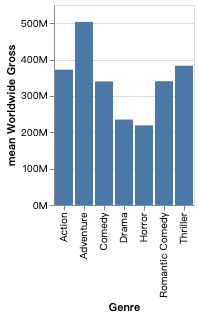

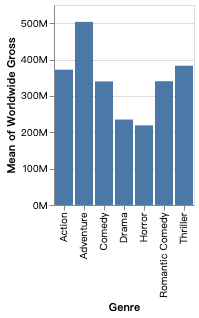

In [5]:
data_position = '../../assets/data/movies-w-year.csv'
vl_spec = {'$schema': 'https://vega.github.io/schema/vega-lite/v4.json',
 'data': {'format': {'type': 'csv'},
          'url': '../../assets/data/movies-w-year.csv'},
 'encoding': {'x': {'field': 'Genre', 'type': 'nominal'},
              'y': {'aggregate': 'mean',
                    'axis': {'format': 's'},
                    'field': 'Worldwide Gross',
                    'type': 'quantitative'}},
 'mark': {'tooltip': True, 'type': 'bar'},
 'transform': [{'filter': 'lower(datum["Worldwide Gross"]) > 100000000.0'},
               {'filter': {'field': 'Creative Type',
                           'oneOf': ['Science Fiction', 'Fantasy']}}]}
show_transform_process(vl_spec, data_position, 'Title')
VegaLite(vl_spec)


In [4]:
df = pd.read_excel("final_merged.xlsx")

In [5]:
df

,Genre,Title,Worldwide Gross,mean Worldwide Gross
0,Action,2012,766812167,372087111.0
1,NaN,End of Days,212026975,NaN
2,NaN,Godzilla,376000000,NaN
3,NaN,Minority Report,358824714,NaN
4,NaN,Resident Evil: Extinction,146162920,NaN
...,...,...,...,...
61,Romantic Comedy,Enchanted,340384141,340384141.0
62,Thriller,District 9,206552113,383012970.5
63,NaN,Inception,753830280,NaN
64,NaN,Signs,408265690,NaN


In [6]:
{'type': 'aggregation', 'op': 'sum', 'agg_field': 'Worldwide Gross', 'agg_dim': 'y', 'groupby':['Genre','Content Rating']}


{'type': 'aggregation',
 'op': 'sum',
 'agg_field': 'Worldwide Gross',
 'agg_dim': 'y',
 'groupby': ['Genre', 'Content Rating']}

In [9]:
df = pd.read_csv('../../assets/data/movies-w-year.csv') 
overview_df = df[['Worldwide Gross','Genre','Content Rating','Title']]
overview_df

,Worldwide Gross,Genre,Content Rating,Title
0,25728961,Horror,R,From Dusk Till Dawn
1,148345997,Action,R,Broken Arrow
2,20278055,Drama,R,City Hall
3,38623460,Comedy,PG-13,Happy Gilmore
4,51204567,Thriller,R,Fargo
...,...,...,...,...
704,493296,Drama,PG-13,The City of Your Final Destination
705,310885538,Action,PG-13,Robin Hood
706,753830280,Thriller,PG-13,Inception
707,43149143,Comedy,PG-13,Scott Pilgrim vs. The World


In [13]:
ref_dict=overview_df.groupby(['Genre','Content Rating']).sum(['Worldwide Gross'])#.to_dict()
ref_dict

Worldwide Gross
Genre           Content Rating                 
Action          PG                     17220599
                PG-13               15422900884
                R                   11046491267
Adventure       G                    4413727463
                PG                   9402901952
...                                         ...
Romantic Comedy R                    1527690583
Thriller        PG-13                6430530401
                R                    3801296054
Western         PG-13                 178526493
                R                     176339041

[30 rows x 1 columns]

In [14]:
group__dict = overview_df.groupby(['Genre','Content Rating','Title']).sum(['Worldwide Gross'])#.to_dict()
group__dict

Worldwide Gross
Genre   Content Rating Title                            
Action  PG             The Phantom              17220599
        PG-13          12 Rounds                18184083
                       2 Fast 2 Furious        236220058
                       2012                    766812167
                       After the Sunset         38329114
...                                                  ...
Western PG-13          Hidalgo                 107336658
                       Shanghai Noon            71189835
        R              3:10 to Yuma             69791889
                       Open Range               68293719
                       The Missing              38253433

[709 rows x 1 columns]